In [1]:
# Sample API
import mae6225
mae6225.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

Re   = 100.0
dt   = 0.01
tmax = 10.

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc','asol','eror']
face_vars   = ['velc', 'hvar','asol','eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 1.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = mae6225.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = mae6225.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = mae6225.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

In [5]:
t  = 0.0
nt = 0

ins_stats = dict()

rk3_coeff = [[0,1/3,1/3],[-5/9,15/16,5/12],[-153/128,8/15,1/4]]

while t <= tmax:
    for hconst, tconst1, tconst2 in rk3_coeff:
        # Calculate predicted velocity: u* = dt*H(u^n)
        mae6225.ins.predictor_rk3(gridx, gridy, 'velc', 'hvar', Re, dt*tconst1, hconst)
        # Calculate RHS for the pressure Poission solver div(u)/dt
        mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=tconst2*dt)
        # Solve the pressure Poisson equation 
        ins_stats['ites'], ins_stats['res'] = mae6225.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                                                           maxiter=10000, tol=1e-9)
        # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
        mae6225.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', tconst2*dt)

    # Calculate divergence of the corrected velocity to display stats
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    ins_stats.update(mae6225.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if nt % 10 == 0:
        mae6225.io.display_stats(t, ins_stats)   
    
    t += dt
    nt += 1
    

------------ Time = 0.0 ---------------
Number of poisson iterations    : 5417
Final poisson residual : 9.989898741374885e-10
Max, Min, U   : 2.0, -0.11856262172448331
Max, Min, V   : 0.28933607325929506, -0.28933607325929506
Max, Min, P   : 0.9874748858020544, -0.7361091129104015
Max, Min, DIV : 2.4632401935016646e-08, -2.4671201970249967e-08


------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : 3056
Final poisson residual : 9.993744980562317e-10
Max, Min, U   : 2.0, -0.1363023123419955
Max, Min, V   : 0.3210434060961012, -0.36371378129831666
Max, Min, P   : 1.220350688538601, -0.786825215274718
Max, Min, DIV : 2.249602012625255e-08, -2.327510273403277e-08




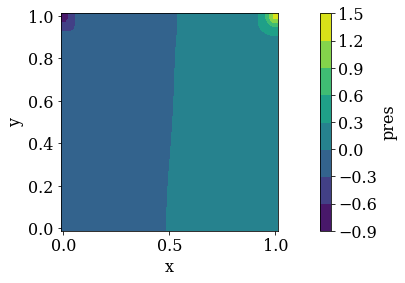

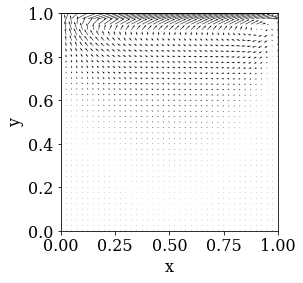

In [6]:
mae6225.io.plot_contour(gridc, 'pres')
mae6225.io.plot_vector(gridx,gridy,'velc')